In [1]:
%load_ext autoreload
%autoreload 2 
%cd ~/arga/nerf-thesis/

/proj/nlp4adas/users/x_artga/nerf-thesis


In [2]:
from pathlib import Path

from src.diffusion import ImageToImageDiffusionModel
from src.configuration import setup_project
from src.data import load_img_paths_from_dir, read_image

config = setup_project(config_path=None)
dataset_config = config["datasets"]["pandaset"]
dataset_path = Path(dataset_config["path"])
data_path = dataset_path / dataset_config["scenes"][0] / "camera" / "front_camera"

img_paths = load_img_paths_from_dir(data_path)
ex_img = read_image(img_paths[0])

pipe = ImageToImageDiffusionModel(low_mem_mode=True, disable_grad=True)


/proj/nlp4adas/master-thesis-shared/nerf-thesis-env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/proj/nlp4adas/master-thesis-shared/nerf-thesis-env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


/proj/nlp4adas/users/x_artga/nerf-thesis/proj_config.yml


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

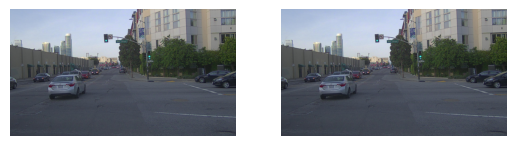

In [3]:
import matplotlib.pyplot as plt
from src.utils import show_img

# Check VAE
img_pp = pipe.pipe.image_processor.preprocess(ex_img)

plt, (ax1, ax2) = plt.subplots(1, 2)
show_img(ex_img, ax1)
show_img((img_pp[0] + 1) / 2 , ax2)

In [17]:
pipe.pipe.image_processor.config

FrozenDict([('do_resize', True),
            ('vae_scale_factor', 8),
            ('resample', 'lanczos'),
            ('do_normalize', True),
            ('do_binarize', False),
            ('do_convert_rgb', False),
            ('do_convert_grayscale', False),
            ('_use_default_values',
             ['do_convert_rgb',
              'resample',
              'do_convert_grayscale',
              'do_resize',
              'do_binarize',
              'do_normalize'])])

In [18]:
ex_img.max(), ex_img.shape, ex_img.dtype

(tensor(1.), torch.Size([3, 1080, 1920]), torch.float32)

In [19]:
img_pp.max(), img_pp.shape, img_pp.dtype

(tensor(1.), torch.Size([1, 3, 1080, 1920]), torch.float32)

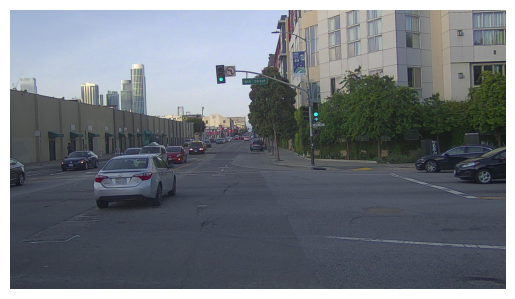

In [4]:
img_npp = pipe.pipe.image_processor.postprocess(img_pp, output_type="pt")

show_img(img_npp[0])

In [5]:
import torch
seeds = [0]
img_out = pipe(prompt="", image=ex_img, seeds=seeds)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
len(img_out), img_out[0].shape, img_out.shape

(1, torch.Size([3, 1080, 1920]), torch.Size([1, 3, 1080, 1920]))

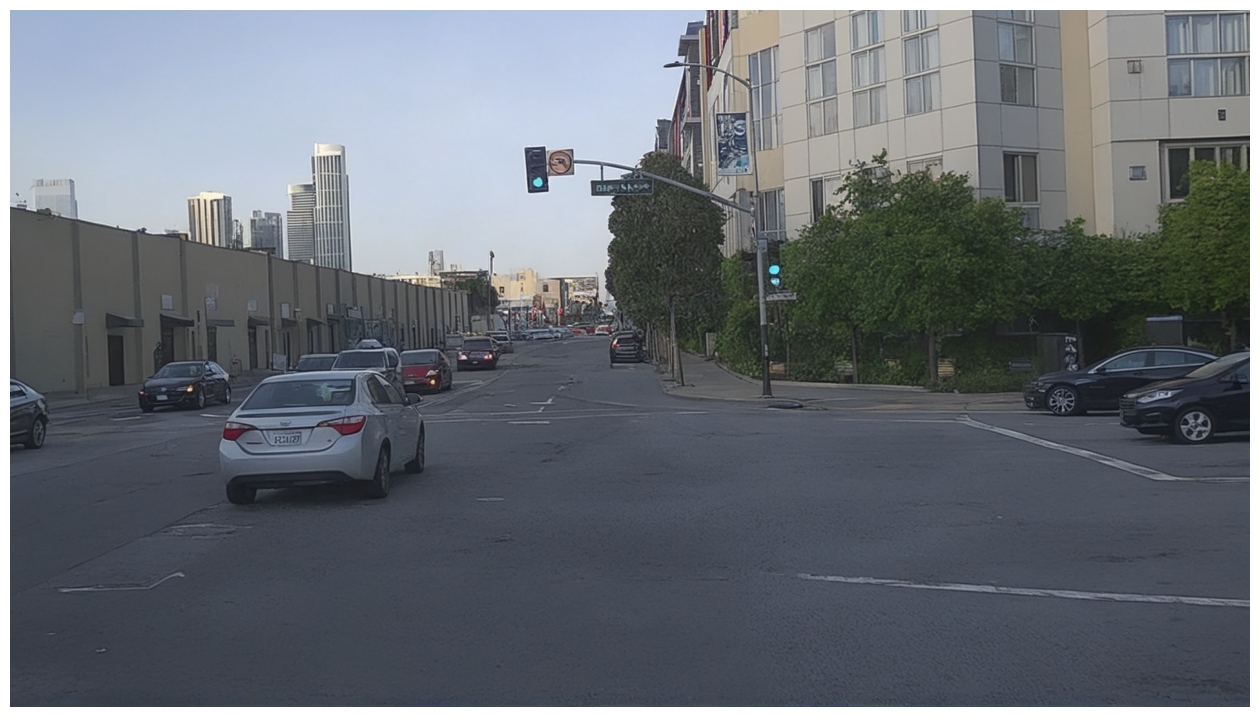

In [7]:
import matplotlib.pyplot as plt
from torch import Tensor
from src.utils import show_img

show_img(img_out)

In [10]:
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl_img2img import retrieve_latents


pipe.pipe.upcast_vae()
latents_raw = pipe.pipe.vae.encode(img_pp.to("cuda"))
latents = retrieve_latents(latents_raw, generator=torch.manual_seed(0))
latents = latents * pipe.pipe.vae.config.scaling_factor
latents = latents.to("cpu")

In [11]:
#needs_upcasting = pipe.pipe.vae.dtype == torch.float16 and pipe.pipe.vae.config.force_upcast

pipe.pipe.upcast_vae()
latents = latents.to(next(iter(pipe.pipe.vae.post_quant_conv.parameters())).dtype)



In [29]:
needs_upcasting

False

In [27]:
latents.shape

torch.Size([1, 4, 135, 240])

In [12]:
torch.cuda.empty_cache()
img_dec = pipe.pipe.vae.decode(latents / pipe.pipe.vae.config.scaling_factor, return_dict=False)[0]

In [36]:
print(pipe.pipe.vae.config.scaling_factor)

0.13025


In [35]:
print(img_dec.shape, img_dec.max(), img_dec.min())

torch.Size([1, 3, 1080, 1920]) tensor(2.9018, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-4.2363, device='cuda:0', grad_fn=<MinBackward1>)


In [13]:
img_npp_dec = pipe.pipe.image_processor.postprocess(img_dec, output_type="pt")

In [18]:
show_img([ex_img[None, ...], img_npp_dec])

[autoreload of src.diffusion failed: Traceback (most recent call last):
  File "/proj/nlp4adas/master-thesis-shared/nerf-thesis-env/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/proj/nlp4adas/master-thesis-shared/nerf-thesis-env/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/proj/nlp4adas/master-thesis-shared/nerf-thesis-env/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/proj/nlp4a

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [ ]:

pipe.pipe.vae

In [48]:
!PYTHONPATH='.' python scripts/run_diffusion.py ~/base/master-thesis-shared/renders/radnerf/pandaset-neurad/neurad-pandaset-test-001/test/rgb/front_camera/ ~/base/master-thesis-shared/diffusions/sdxl_ref_v1_0/radnerf/pandaset-neurad/neurad-pandaset-test-001/test/rgb/front_camera/

/opt/mambaforge/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/mambaforge/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/proj/nlp4adas/users/x_artga/nerf-thesis/proj_config.yml
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


In [7]:
from src.sdxl_rewrite import UNet2DConditionModel


old_unet = pipe.pipe.unet
new_unet = UNet2DConditionModel()


In [ ]:
pipe.pipe.unet = 

In [ ]:
from diffusers.image_processor import VaeImageProcessor
from diffusers import AutoencoderKL
from torch import Tensor

def encode_decode(image_processor: VAEImageProcessor, vae: AutoencoderKL, img: Tensor) -> Tensor:
    img_pp = image_processor.preprocess(img)